# Model Predictive Control example

In [1]:
from rockit import *
from casadi import *

import matplotlib.pyplot as plt
import numpy as np

## Problem parameters

In [2]:
mcart = 0.5                 # cart mass [kg]
m     = 1                   # pendulum mass [kg]
L     = 2                   # pendulum length [m]
g     = 9.81                # gravitation [m/s^2]

nx    = 4                   # the system is composed of 4 states
nu    = 1                   # the system has 1 input
Tf    = 2.0                 # horizon size [s]
Nhor  = 50                  # number of control intervals
dt    = Tf/Nhor             # sampling time

current_X = vertcat(0.5,0,0,0)  # initial state
final_X   = vertcat(0,0,0,0)    # desired terminal state

Nsim  = 200                 # how much samples to simulate: total simulation time = Nsim*dt [s]
add_noise = True            # enable/disable the measurement noise addition in simulation
add_disturbance = True      # enable/disable the disturbance addition in simulation

## Logging variables

In [3]:
pos_history     = np.zeros(Nsim+1)
theta_history   = np.zeros(Nsim+1)
F_history       = np.zeros(Nsim)

## Set OCP

In [4]:
ocp = Ocp(T=Tf)

# Define states
pos    = ocp.state()  # [m]
theta  = ocp.state()  # [rad]
dpos   = ocp.state()  # [m/s]
dtheta = ocp.state()  # [rad/s]

# Defince controls
F = ocp.control(nu, order=0)

# Define parameter
X_0 = ocp.parameter(nx);

# Specify ODE
ocp.set_der(pos, dpos)
ocp.set_der(theta, dtheta)
ocp.set_der(dpos, (-m*L*sin(theta)*dtheta*dtheta + m*g*cos(theta)*sin(theta)+F)/(mcart + m - m*cos(theta)*cos(theta)) )
ocp.set_der(dtheta, (-m*L*cos(theta)*sin(theta)*dtheta*dtheta + F*cos(theta)+(mcart+m)*g*sin(theta))/(L*(mcart + m - m*cos(theta)*cos(theta))))

# Lagrange objective
ocp.add_objective(ocp.integral(F*2 + 100*pos**2))

# Initial constraints
X = vertcat(pos,theta,dpos,dtheta)
ocp.subject_to(ocp.at_t0(X)==X_0)
ocp.subject_to(ocp.at_tf(X)==final_X)

# Path constraints
ocp.subject_to(-2 <= (F <= 2 ))
# Note: pos is already fixed at t0 by initial constraints
#       include_first False avoids adding a redundant constraint 
ocp.subject_to(-2 <= (pos <= 2), include_first=False)


# Pick a solution method
options = {"ipopt": {"print_level": 0}}
options["expand"] = True
options["print_time"] = False
ocp.solver('ipopt',options)

# Make it concrete for this ocp
ocp.method(MultipleShooting(N=Nhor,M=1,intg='rk'))

## Solve the OCP w.r.t. a parameter value (for the first time)

In [5]:
# Set initial value for parameters
ocp.set_value(X_0, current_X)
# Solve
sol = ocp.solve()

# Get discretisd dynamics as CasADi function
Sim_pendulum_dyn = ocp._method.discrete_system(ocp)

# Log data for post-processing
pos_history[0]   = current_X[0]
theta_history[0] = current_X[1]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



## Simulate the MPC solving the OCP (with the updated state) several times

In [6]:
DM.rng(0)

for i in range(Nsim):
    print("timestep", i+1, "of", Nsim)
    # Get the solution from sol
    tsa, Fsol = sol.sample(F, grid='control')
    # Simulate dynamics (applying the first control input) and update the current state
    current_X = Sim_pendulum_dyn(x0=current_X, u=Fsol[0], T=dt)["xf"]
    # Add disturbance at t = 2*Tf
    if add_disturbance:
        if i == round(2*Nhor)-1:
            disturbance = vertcat(0,0,-1e-1,0)
            current_X = current_X + disturbance
    # Add measurement noise
    if add_noise:
        meas_noise = 5e-4*(DM.rand(nx,1)-vertcat(1,1,1,1)) # 4x1 vector with values in [-1e-3, 1e-3]
        current_X = current_X + meas_noise
    # Set the parameter X0 to the new current_X
    ocp.set_value(X_0, current_X[:4])
    # Solve the optimization problem
    sol = ocp.solve()

    # NOTE: sol.sample/ocp.set_value/ocp.solve
    #       bring about some processing overhead
    #       which may be larger than the actual online optimization
    #       See repeated_solve.py

    # Log data for post-processing
    pos_history[i+1]   = current_X[0].full()
    theta_history[i+1] = current_X[1].full()
    F_history[i]       = Fsol[0]


timestep 1 of 200
timestep 2 of 200
timestep 3 of 200
timestep 4 of 200
timestep 5 of 200
timestep 6 of 200
timestep 7 of 200
timestep 8 of 200
timestep 9 of 200
timestep 10 of 200
timestep 11 of 200
timestep 12 of 200
timestep 13 of 200
timestep 14 of 200
timestep 15 of 200
timestep 16 of 200
timestep 17 of 200
timestep 18 of 200
timestep 19 of 200
timestep 20 of 200
timestep 21 of 200
timestep 22 of 200
timestep 23 of 200
timestep 24 of 200
timestep 25 of 200
timestep 26 of 200
timestep 27 of 200
timestep 28 of 200
timestep 29 of 200
timestep 30 of 200
timestep 31 of 200
timestep 32 of 200
timestep 33 of 200
timestep 34 of 200
timestep 35 of 200
timestep 36 of 200
timestep 37 of 200
timestep 38 of 200
timestep 39 of 200
timestep 40 of 200
timestep 41 of 200
timestep 42 of 200
timestep 43 of 200
timestep 44 of 200
timestep 45 of 200
timestep 46 of 200
timestep 47 of 200
timestep 48 of 200
timestep 49 of 200
timestep 50 of 200
timestep 51 of 200
timestep 52 of 200
timestep 53 of 200
ti

## Plot the results

Plot the results


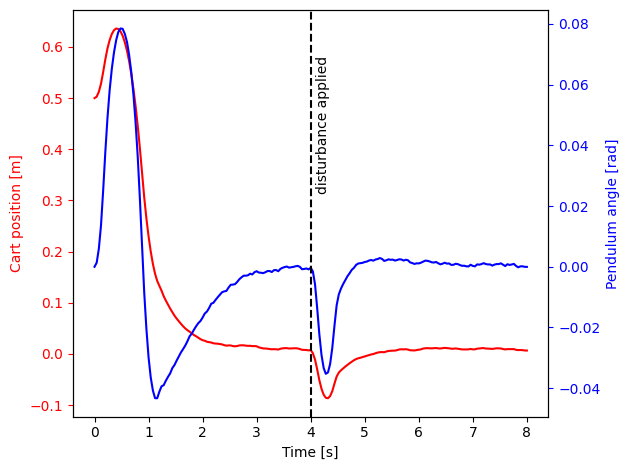

In [7]:
print("Plot the results")
time_sim = np.linspace(0, dt*Nsim, Nsim+1)

fig, ax1 = plt.subplots()
ax1.plot(time_sim, pos_history, 'r-')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Cart position [m]', color='r')
ax1.tick_params('y', colors='r')
ax2 = ax1.twinx()
ax2.plot(time_sim, theta_history, 'b-')
ax2.set_ylabel('Pendulum angle [rad]', color='b')
ax2.tick_params('y', colors='b')
ax2.axvline(x=2*Tf, color='k', linestyle='--')
ax2.text(2*Tf+0.1,0.025,'disturbance applied',rotation=90)
fig.tight_layout()

## Animate results

Animate results


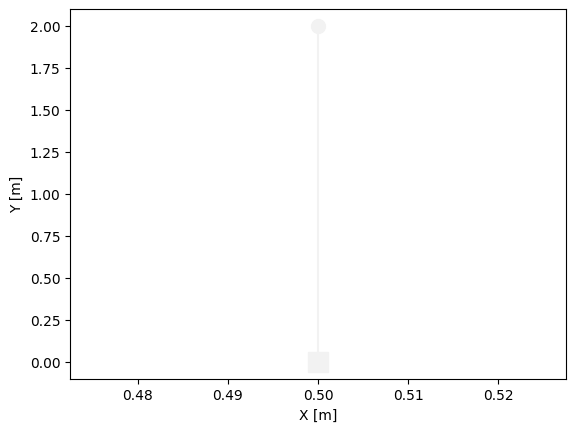

show
end


In [9]:
print("Animate results")

plt.ion() # Enable plt interactive
if plt.isinteractive(): #False:# 
  fig2, ax3 = plt.subplots()
  plt.ion()
  ax3.set_xlabel("X [m]")
  ax3.set_ylabel("Y [m]")
  for k in range(Nsim+1):
      cart_pos_k      = pos_history[k]
      theta_k         = theta_history[k]
      pendulum_pos_k  = vertcat(horzcat(cart_pos_k,0), vertcat(cart_pos_k-L*sin(theta_k),L*cos(theta_k)).T)
      color_k     = 3*[0.95*(1-float(k)/Nsim)]
      ax3.plot(pendulum_pos_k[0,0], pendulum_pos_k[0,1], "s", markersize = 15, color = color_k)
      ax3.plot(pendulum_pos_k[:,0], pendulum_pos_k[:,1], "-", linewidth = 1.5, color = color_k)
      ax3.plot(pendulum_pos_k[1,0], pendulum_pos_k[1,1], "o", markersize = 10, color = color_k)
      plt.pause(dt)

print("show")
plt.show(block=True)
print("end")